In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

os.environ["OPENAI_API_KEY"] = "sk-tejMSVz1e3ziu6nB0yP2wLiaCUp2jR4Jtf4uaAoXNro6YXmh"
os.environ["LANGCHAIN_API_KEY"] = "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"


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")


# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Bio3_agent"

from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

from tools import *
tool_list = [do_freelance_job, navigate_to, sleep]



prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()





{'code': 400, 'message': 'You cannot sleep.'}
{'code': 200, 'maplength': 5.3, 'message': 'Movement completed successfully'}
{'code': 200, 'cashreward': 169.05, 'message': 'Freelance job completed successfully'}
================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


/Users/rick/miniconda3/envs/bio3/lib/python3.10/site-packages/langsmith/client.py:5489: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [2]:
llm = ChatOpenAI(base_url="https://api.aiproxy.io/v1",model="gpt-4o")
agent_executor = create_react_agent(llm, tool_list, messages_modifier=prompt)

/var/folders/sb/pqph_qdx7ts98qwv2rjpqw080000gn/T/ipykernel_7064/571500258.py:2: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tool_list, messages_modifier=prompt)


In [3]:
agent_executor.invoke({"messages": [("user", "Please go to the farm ,do freelance job, then go to toilet, then go home then sleep")]})


{'messages': [HumanMessage(content='Please go to the farm ,do freelance job, then go to toilet, then go home then sleep', id='f19dce8e-792a-4f83-8ff2-4e096a5607b9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PMwwFU6N8sOaLr98YF7XVl0f', 'function': {'arguments': '{"to": "farm"}', 'name': 'navigate_to'}, 'type': 'function'}, {'id': 'call_6yi3Fp2xTO4trqHJ8NyJaPP5', 'function': {'arguments': '{"timelength": 1}', 'name': 'do_freelance_job'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 128, 'total_tokens': 178}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-95a06014-4259-42d3-aaca-6bda48d49121-0', tool_calls=[{'name': 'navigate_to', 'args': {'to': 'farm'}, 'id': 'call_PMwwFU6N8sOaLr98YF7XVl0f', 'type': 'tool_call'}, {'name': 'do_freelance_job', 'args': {'timelength': 1}, 'id': 'call_6yi3Fp2xTO4trqHJ8NyJaPP5', 'type': '

In [4]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str
    #reward : float

In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [6]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1",model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [7]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1",model="gpt-4o", temperature=0
).with_structured_output(Act)

In [8]:
from typing import Literal

# Helper function to extract reward from the response
# def extract_reward(response: str) -> int:
#     # Implement logic to extract reward from the response
#     # For example, if the response contains "reward: 1000", extract 1000
#     import re
#     match = re.search(r"reward: (\d+)", response)
#     if match:
#         return int(match.group(1))
#     return 0


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )

    #Extract the reward from the agent_response
    #TODO BUGGY
    # if "freelance" in task:
    #     reward = extract_reward(agent_response["messages"][-1].content)
    #     print(reward)
    #     state["reward"] = reward

    

    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["Executor", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "Executor"

In [9]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("Objectives_planner", plan_step)

# Add the execution step
workflow.add_node("Executor", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "Objectives_planner")

# From plan we go to agent
workflow.add_edge("Objectives_planner", "Executor")

# From agent, we replan
workflow.add_edge("Executor", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
)

app = workflow.compile()

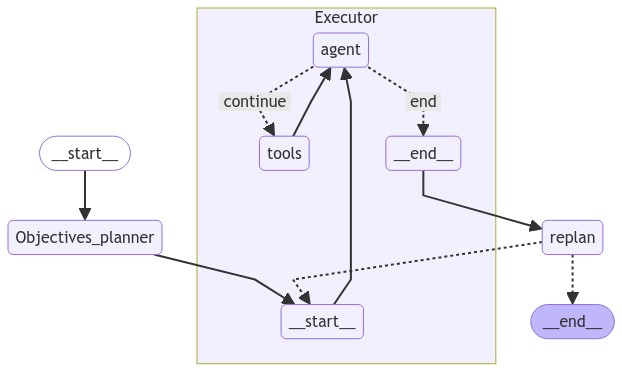

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [11]:
config = {"recursion_limit": 10}
inputs = {"input": "go to the farm and do freelance job, go home and sleep"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Go to the farm', 'Do freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Go to the farm', "I have successfully navigated to the farm. What's next on your plan?")]}
{'plan': ['Do freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Do freelance job', 'How many hours should I allocate for the freelance job?')]}
{'plan': ['Allocate hours for the freelance job', 'Complete the freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Allocate hours for the freelance job', 'How many hours would you like to allocate for the freelance job?')]}
{'plan': ['Complete the freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Complete the freelance job', 'The freelance job has been completed successfully, earning a cash reward of $73.10. Now you can proceed to go home and then sleep.')]}
{'plan': ['Go home', 'Sleep']}
